# Vocabulary and bias analysis

The aim of this notebook is to perform some basic analysis on the vocabulary set of both 8K and 30K image captions. We want to analyze a few things:
* Word frequencies - how frequently words repeat + which words are most common
* Distribution of POS 
* Name-entity recognition
* Color distribution
* Gender distribution (use embeddings to get a tone?)
* Ethinicity distribution


# _0. Data Import_

**Which dataset?**


In [1105]:
# get the tokenized dataset
file = "tokenized_30kcaptions.txt"

**Import the data**: We import the tokenized data, remove the image names

In [1106]:
import pandas as pd
import os, sys, string

with open(file, "r") as f:
    data = f.readlines()

# isolate just the captions and remove the column header
captions = [line.split(",")[1].strip() for line in data]
captions = captions[1:]

**Duplicate and non-duplicate sets**: Creating two bags for the vocabulary, one with duplicates and one without.

In [1107]:
import numpy as np
import pandas as pd

# assimilate all the tokens into a single array
split_list = [line.split() for line in captions]
single_list = [j for sub in split_list for j in sub]

# create arrays with duplication and without
unq_arr = np.unique(np.array(single_list))
dup_arr = np.array(single_list)

# convert all to lowercase
unq_arr = [word.lower() for word in unq_arr]
dup_arr = [word.lower() for word in dup_arr]

# create dfs with duplication and without
unq_df = pd.DataFrame(data=unq_arr, columns=["word"])
dup_df = pd.DataFrame(data=dup_arr, columns=["word"])

# _1. Word Frequencies_

**WordCloud of top n most recurring words**

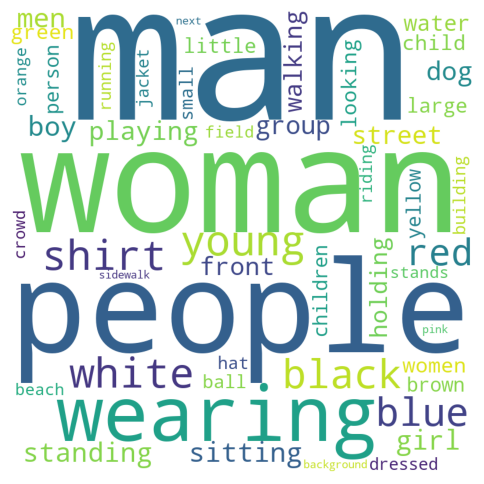

In [1108]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# all stop words
stopwords = set(STOPWORDS)
# top n words
top_n = 50

# get counts for all the words and sort 
dup_counts = dup_df.groupby('word')['word'] \
                    .count() \
                    .reset_index(name = 'count') \
                    .sort_values(by="count", ascending=False)

# filter out stop words
dup_counts = dup_counts[~dup_counts["word"].isin(stopwords)]

# get top_n rows 
rows_n = dup_counts.head(top_n).set_index('word')
# final words in dictionary form
rows_n_dict = rows_n.to_dict()['count']

# build the wordcloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10,
                max_words = len(rows_n_dict)).generate_from_frequencies(rows_n_dict)

# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**How often are words repeated?**

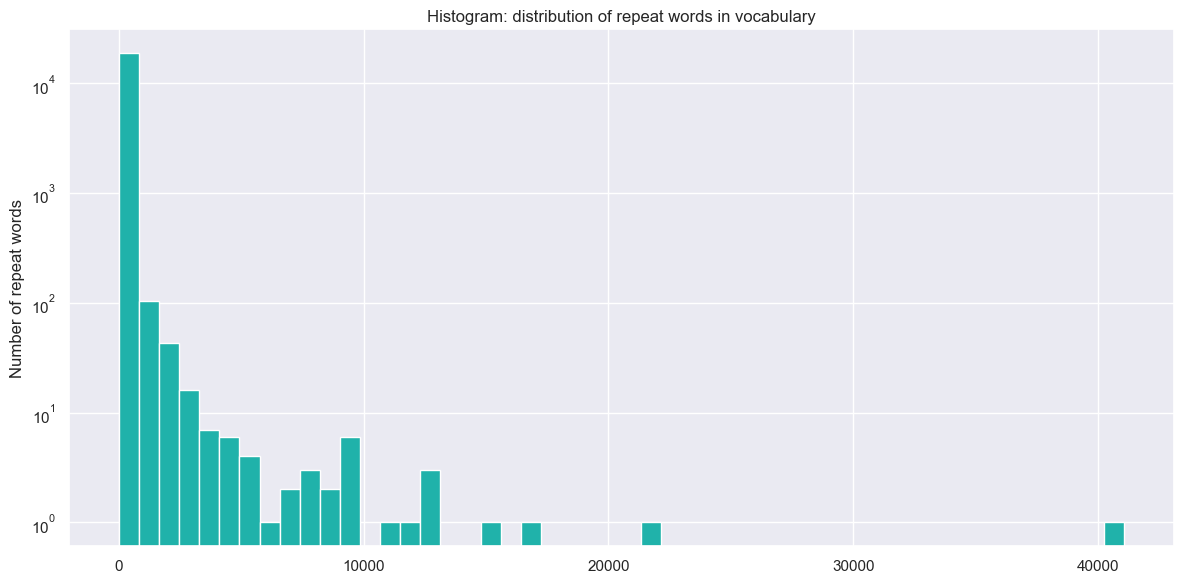

In [1109]:
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

# all stop words
stopwords = set(STOPWORDS)

# get counts for all the words and sort 
dup_counts = dup_df.groupby('word')['word'] \
                    .count() \
                    .reset_index(name = 'count') \
                    .sort_values(by="count", ascending=False)

# filter out stop words
dup_counts = dup_counts[~dup_counts["word"].isin(stopwords)]

# create histogram of how frequently repeats occur
plt.figure(figsize = (12,6), facecolor='white')

plt.hist(dup_counts['count'], bins = 50, color='lightseagreen')

plt.ylabel("Number of repeat words")
plt.yscale('log')

plt.title("Histogram: distribution of repeat words in vocabulary")
plt.show()


# _2. Parts of Speech Distribution_

**Tagging the duplicate dataset using NLTK**

In [1110]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import STOPWORDS

# all stop words
stopwords = set(STOPWORDS)
# filter out stop words
dup_df_filt = dup_df[~dup_df["word"].isin(stopwords)]

# get all POS tags
tagged = nltk.pos_tag(dup_df_filt['word'])

**Creating plot**

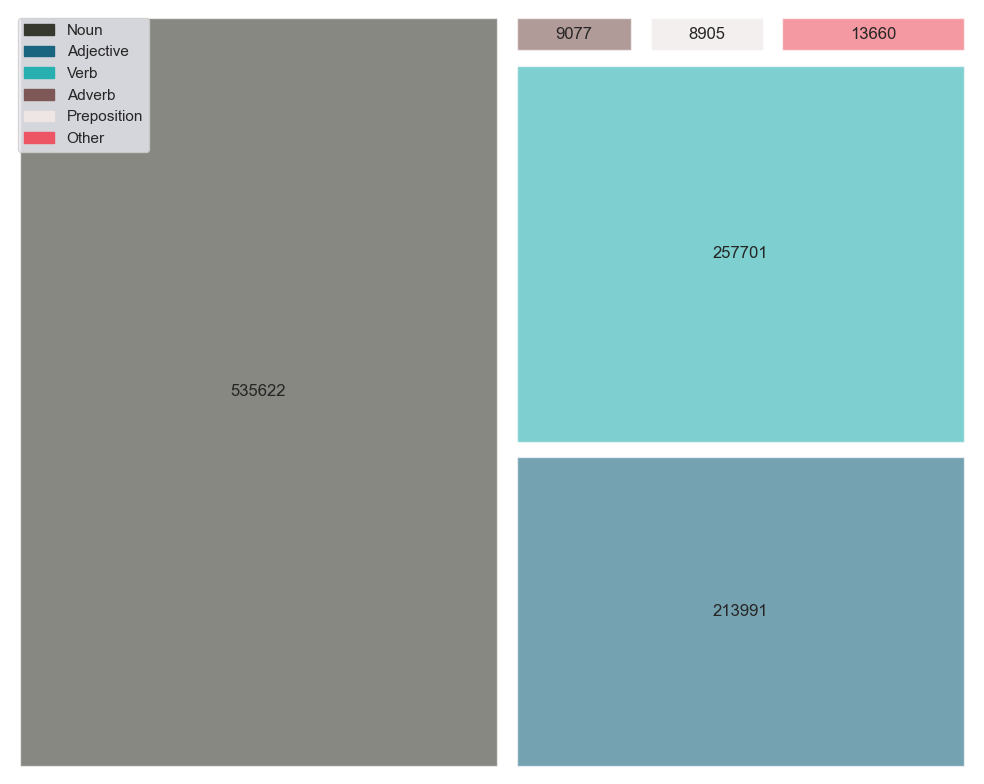

In [1111]:
import pandas as pd 
import squarify
import matplotlib.patches as mpatches

tagged_df = pd.DataFrame(tagged, columns=["word", "POS"])

pos_counts = tagged_df.groupby('POS')['POS'] \
                    .count() \
                    .reset_index(name = 'count') \
                    .sort_values(by="count", ascending=False)


# get the important POS
pos_important = ["NN", "NNS","NNP","NNPS", "JJ", "JJR","JJS", 
                 "VB", "VBD", "VBG", "VBN", "VBP", "VBZ",
                 "RBR", "RBS", "IN"]

nouns = pos_counts[pos_counts['POS'].str.startswith("NN")]
adjectives = pos_counts[pos_counts['POS'].str.startswith("JJ")]
verbs = pos_counts[pos_counts['POS'].str.startswith("VB")]
adverbs = pos_counts[pos_counts['POS'].str.startswith("RB")]
preps = pos_counts[pos_counts['POS'].str.startswith("IN")]

# auxiliary "other" POS
aux_pos_count = pos_counts[~pos_counts['POS'].isin(pos_important)]['count'].sum()

# get the final POS df
final_pos = {   "Noun":        nouns['count'].sum(),
                "Adjective":   adjectives['count'].sum(),
                "Verb":        verbs['count'].sum(),
                "Adverb":      adverbs['count'].sum(),
                "Preposition": preps['count'].sum(),
                "Other":       aux_pos_count
              }
              
final_pos_df = pd.DataFrame.from_dict(data=final_pos, orient='index', columns=["count"])

# set seaborn plot style
sns.set_style(style="darkgrid") 
sns.set(rc={'figure.figsize':(10,8)})

sizes = final_pos_df["count"].values
label = final_pos_df.index

# get color and legend ready
colors = ["#37392E", "#19647E", "#28AFB0", "#7E5856", "#EEE5E5", "#ED5564"]

p1 = mpatches.Patch(color=colors[0], label='Noun')
p2 = mpatches.Patch(color=colors[1], label='Adjective')
p3 = mpatches.Patch(color=colors[2], label='Verb')
p4 = mpatches.Patch(color=colors[3], label='Adverb')
p5 = mpatches.Patch(color=colors[4], label='Preposition')
p6 = mpatches.Patch(color=colors[5], label='Other')

plt.legend(handles=[p1,p2,p3,p4,p5,p6])


squarify.plot(sizes=sizes, label=sizes, alpha=0.6, pad=True, color=colors)
plt.axis('off')
plt.show()


# _3. Name-Entity Recognition_

**Get entity label for unique words**

In [1112]:
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import STOPWORDS
 
# all stop words
stopwords = set(STOPWORDS)
# filter out stop words
dup_df_filt = dup_df[~dup_df["word"].isin(stopwords)]
unq_df_filt = dup_df_filt.drop_duplicates(subset=['word'])

# create df with the entity label
entity_df = unq_df_filt.copy()
entity_df['entity'] = entity_df['word'].apply(lambda x: nlp(x).ents)
entity_df['label'] = entity_df['entity'].apply(lambda x: 0 if x ==() else x[0].label_)
label_df = entity_df.drop(columns=["entity"])

**Join with full dataset**

In [1113]:
merged_label_df = pd.merge(dup_df_filt, label_df, on="word")

## Ethnicity Analysis

In [1114]:
eths = merged_label_df[merged_label_df['label'] == "NORP"]
eths_sorted = eths.groupby('word')['word'] \
                    .count() \
                    .reset_index(name = 'count') \
                    .sort_values(by="count", ascending=False)

**Remove outliers** 

In [1115]:
# use csv for nationalities
natList = pd.read_csv('nationality.csv', header=None, names=["nationality","country"])
allNats = natList['nationality'].values.tolist()
allNatsPlural = []
allNats = set([x.lower() for x in allNats])

eths_sorted = eths_sorted[eths_sorted["word"].isin(allNats)]

**Plot**

C:\Users\Rubin\AppData\Local\Temp\ipykernel_16440\2094252344.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_eths = top_eths.append(row, ignore_index = True)


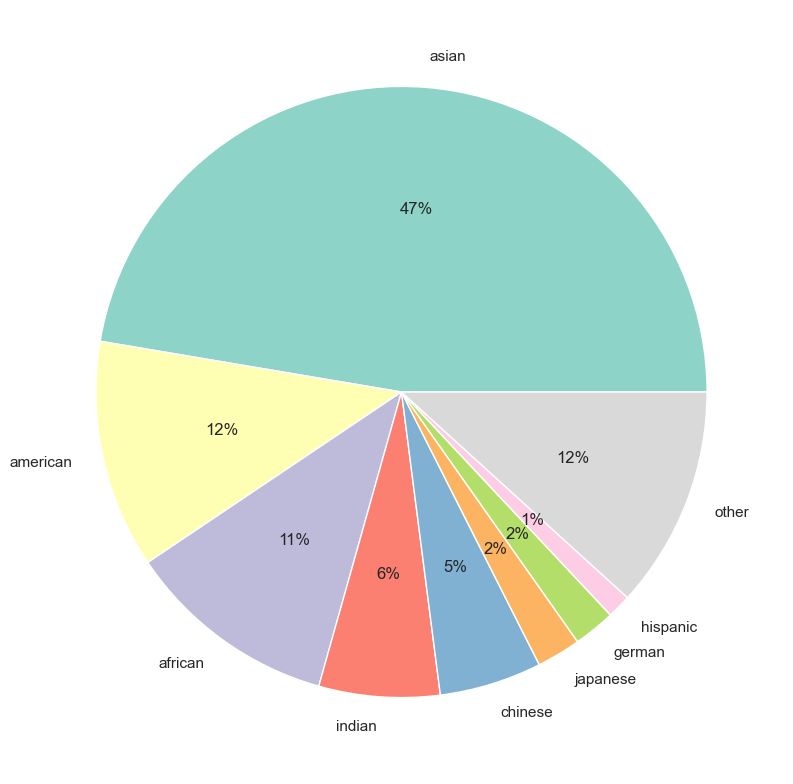

In [1116]:
import matplotlib.pyplot as plt
import seaborn as sns

# top n ethinicities
top_n = 8

# top eths
top_eths = eths_sorted.head(top_n)

# other eths
other_eths = eths_sorted[~eths_sorted["word"].isin(top_eths['word'])]
other_sum = other_eths['count'].sum()

# append other_eths to top_eths
row = {"word" : "other" , "count" : other_sum}
final_eths = top_eths.append(row, ignore_index = True)

# define data
data = final_eths['count'].values
labels = final_eths['word']

# define Seaborn color palette to use
colors = sns.color_palette('Set3', top_n + 1)

# create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

# _4. Color distribution_

In [1117]:
import webcolors
colorList = webcolors.CSS3_NAMES_TO_HEX

color_df = dup_df[dup_df["word"].isin(colorList)]
color_df_sorted = color_df.groupby('word')['word'] \
                          .count() \
                          .reset_index(name = 'count') \
                          .sort_values(by="count", ascending=False)
# black and white
black_count = color_df_sorted[color_df_sorted["word"] == "black"]["count"].values
white_count = color_df_sorted[color_df_sorted["word"] == "white"]["count"].values

# now look at colors
color_only = color_df_sorted[~(color_df_sorted["word"] == "black") & ~(color_df_sorted["word"] == "white")]
top_n_colors = 6
color_only_top = color_only.head(top_n_colors)

color_only_top

,word,count
5,blue,10904
37,red,9586
17,green,5121
51,yellow,4447
6,brown,4332
31,orange,3072


**Plot**

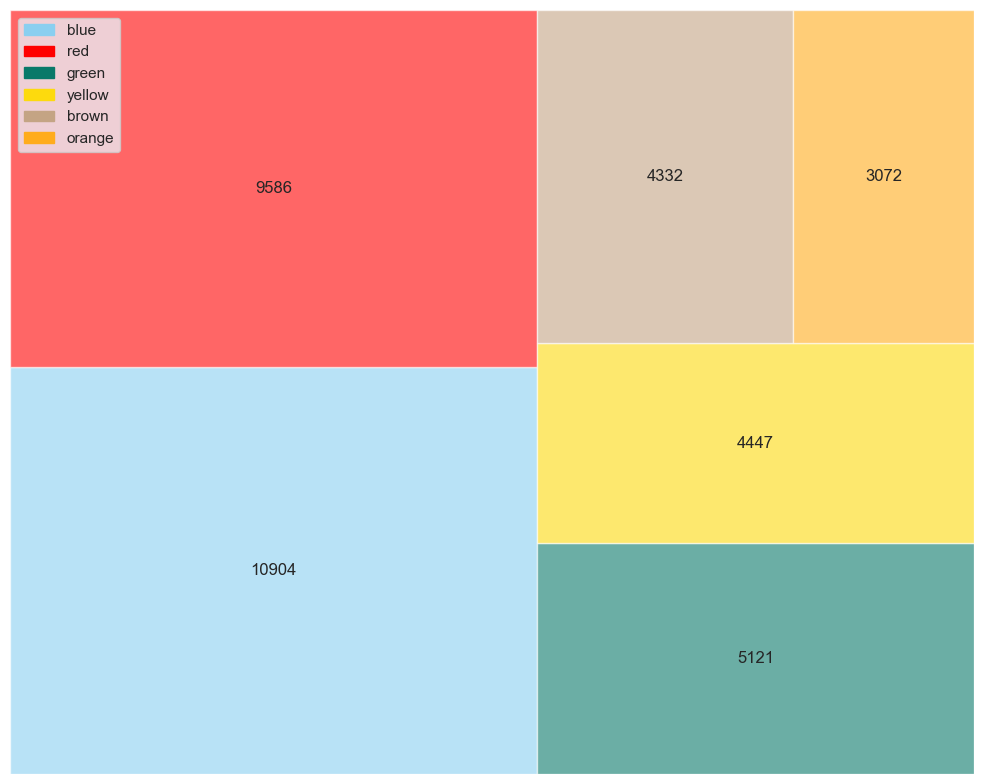

In [1118]:
import squarify
import matplotlib.patches as mpatches

# set seaborn plot style
sns.set_style(style="whitegrid") 
sns.set(rc={'figure.figsize':(10,8)})

sizes = color_only_top['count'].values.tolist()
labels = color_only_top['word'].values.tolist()

# get color and legend ready
colors = ["#89CFF0", "#FF0000", "#097969", "#FDDA0D", "#C4A484",  "#FFAC1C"]

# handles for legend
handles = []
for i in range(len(label)):
    patch = mpatches.Patch(color=colors[i], label=labels[i])
    handles.append(patch)

plt.legend(handles=handles, loc='upper left')


squarify.plot(sizes=sizes, label=sizes, alpha=0.6, color=colors)
plt.axis('off')
plt.show()

# _5. Gender Distribution_

**Load pre-trained gensim model**

In [1119]:
# import gensim.downloader as api

# info = api.info()  # show info about available models/datasets
# model = api.load("glove-wiki-gigaword-300")  # download the model and return as object ready for use

**Find most similar**

In [1120]:
from wordcloud import STOPWORDS
 
# all stop words
stopwords = set(STOPWORDS)
# filter out stop words
dup_df_filt = dup_df[~dup_df["word"].isin(stopwords)]
unq_df_filt = dup_df_filt.drop_duplicates(subset=['word'])

# create df for gender
gender_df = unq_df_filt.copy()
all_words = gender_df["word"].values.tolist()
sim_male = []
sim_female = []

# find similarity with words
for val in all_words:
    try: 
        sim_male.append(np.average(np.array([model.similarity("boy", val),
                                             model.similarity("male", val),
                                             model.similarity("man", val),
                                             model.similarity("guy", val)])))
        
        sim_female.append(np.average(np.array([model.similarity("girl", val),
                                               model.similarity("female", val),
                                               model.similarity("woman", val),
                                               model.similarity("gal", val)])))
    except:
        sim_male.append(-1)
        sim_female.append(-1)
        
gender_df["male"] = sim_male
gender_df["female"] = sim_female

**Joined with full DF and added count()**

In [1121]:
full_gender_df = pd.merge(dup_df_filt, gender_df, on="word")

gender_count_df = full_gender_df.groupby('word')['word'] \
                                  .count() \
                                  .reset_index(name = 'count') \
                                  .sort_values(by="count", ascending=False)
merged_gender_df = pd.merge(full_gender_df, gender_count_df, on="word")
merged_gender_df = merged_gender_df.drop_duplicates(subset=['word'])

**MALE**: in a list of 10, pick out all the male centric words.

In [1122]:
male_sorted = merged_gender_df.sort_values(by=['male', 'count'], ascending=False)
male_sorted.head(10)

,word,male,female,count
53295,man,0.627401,0.416246,41051
478255,boy,0.588669,0.435241,9262
208636,guy,0.536624,0.273441,1422
164347,girl,0.535487,0.565033,9443
288415,woman,0.529701,0.612306,21626
12901,young,0.494401,0.400061,12933
609503,kid,0.472363,0.314135,591
455407,person,0.471008,0.366642,4416
693862,male,0.460074,0.446635,1454
249406,boys,0.434105,0.335287,1963


In [1123]:
male_lst = ["man", "boy", "guy", "male", "boys"]
male_only = male_sorted[male_sorted["word"].isin(male_lst)]
male_sum = male_only["count"].sum()

**FEMALE**: in a list of 10, pick out all the female centric words.

In [1124]:
female_sorted = merged_gender_df.sort_values(by=['female', 'count'], ascending=False)
female_sorted.head(10)

,word,male,female,count
288415,woman,0.529701,0.612306,21626
164347,girl,0.535487,0.565033,9443
596264,female,0.405673,0.511944,1378
693862,male,0.460074,0.446635,1454
730473,mother,0.389001,0.439193,367
478255,boy,0.588669,0.435241,9262
341897,girls,0.374436,0.423566,2665
53295,man,0.627401,0.416246,41051
792617,teenager,0.392956,0.413354,113
383521,women,0.298170,0.412483,5214


In [1125]:
female_lst = ["woman", "girl", "female", "mother", "girls", "women"]
female_only = female_sorted[female_sorted["word"].isin(female_lst)]
female_sum = female_only["count"].sum()

**Plot**

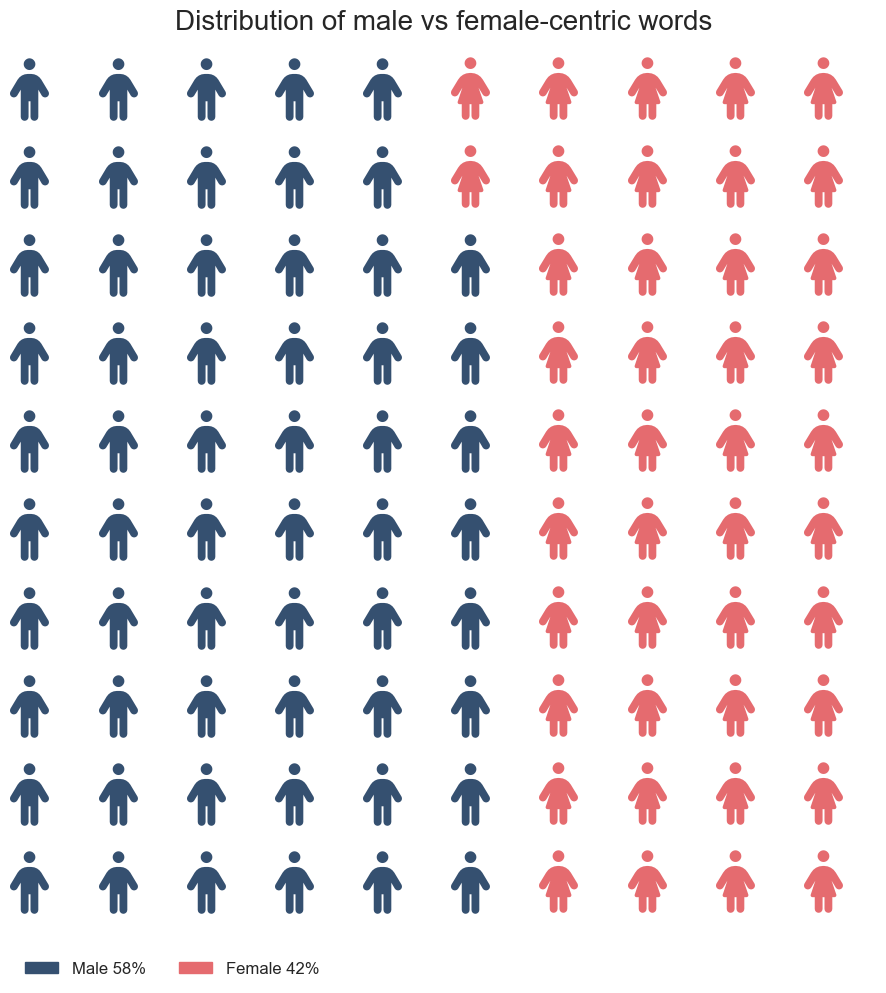

In [1126]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

print("")

total = male_sum + female_sum
scaling = 100

female_scaled = int(female_sum*scaling/total)
male_scaled = 100-female_scaled


# plotting 
title = {'label': 'Distribution of male vs female-centric words',
         'fontdict': {'fontsize': 20}
        }

legend = {'loc': 'lower left',
          'bbox_to_anchor': (0, -0.1),
          'ncol': 2,
          'framealpha': 0,
          'fontsize': 12
         }

plt.figure(
    FigureClass=Waffle,
    
    figsize=(10, 10),
    rows=10,
    
    values=[male_scaled, female_scaled],
    
    icons=['male', 'female'],
    icon_size = 45,
    
    colors=["#355070", "#e56b6f"],
    
    title=title,
    labels=["Male {}%".format(male_scaled), "Female {}%".format(female_scaled)],
    legend=legend

)

plt.show()